# Figure 4 - Deconvolution of Tumor Microenvironment

Pip installation of required packages

In [1]:
#%%capture
#!pip install scanpy adjustText progressbar2 more_itertools leidenalg

In [2]:
%reload_ext autoreload
%autoreload 2
%timeit

# Add repo path to system path if it is not already there
# This allows us to import the package
import sys
GIT_REPO_PATH = "/home/jupyter/github_repos/"
if GIT_REPO_PATH not in sys.path: sys.path.append(GIT_REPO_PATH)

# Set global configuration
!git config --global user.email daniel.charytonowicz@icahn.mssm.edu
!git config --global user.name dchary

# Remove the repo if it exists
#!rm -r /content/external_data/github_"repos/unicell2/
!mkdir /home/jupyter/github_repos/

# Import base packages required
import sys, os, scipy, random, gc, warnings, re, anndata
import numpy as np
import pandas as pd
import scanpy as sc
from importlib import reload
from tqdm.auto import tqdm
import tensorflow as tf
import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt

from ucdeconvolve_old import ucdeconvolve as ucd

mkdir: cannot create directory ‘/home/jupyter/github_repos/’: File exists


2022-12-14 16:58:41.043184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 16:58:41.051319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 16:58:41.052014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 16:58:41.053462: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# Load the unicell basemodel
modelpath = "/home/jupyter/data/unicell_deconvolve_v2.2_10M.h5"
basemodel = tf.keras.models.load_model(modelpath, custom_objects={'tf': tf}, compile = False)

/opt/conda/lib/python3.7/site-packages/keras/layers/core.py:1045: UserWarning: unicell.tensorflow.deconvolve.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


---

# Human Breast Cancer Ductal Carcinoma In Situ (DCIS)

---
Origin: https://www.10xgenomics.com/resources/datasets/human-breast-cancer-ductal-carcinoma-in-situ-invasive-carcinoma-ffpe-1-standard-1-3-0

## Download Data, Process, & Predict

In [ ]:
%%bash
cd /home/jupyter/manuscript/figure4/data/human_breast_dcis/

# Download
aria2c https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5
aria2c https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_spatial.tar.gz
aria2c https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Breast_Cancer/Visium_FFPE_Human_Breast_Cancer_Pathologist_Annotations.png

#Rename visium data
mv Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5 filtered_feature_bc_matrix.h5

# Unpack spatial metadata
tar -xvf Visium_FFPE_Human_Breast_Cancer_spatial.tar.gz

In [ ]:
# Load data
adata = sc.read_visium("data/human_breast_dcis/")
adata = ucd.tl.quickprocess(adata)

# Perform deconvolution
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

In [8]:
# Assign interesting celltypes to unstructured dictionary
adata.uns['interesting_celltypes'] = [
    ('fibroblast', 'primary'), ('brca', 'cancer'), ('t cell', 'primary'), ('macrophage', 'primary'),
    ('igg plasma cell', 'primary'),('endothelial cell','primary')]

# Extract just celltype names
celltype_labels = list(list(zip(*adata.uns['interesting_celltypes']))[0])

# Run explain
expl_brca = ucd.tl.explain(adata, celltype_labels, basemodel, batchsize = 5)

# Save explanations
ucd.tl.write_explanations_to_anndata(adata, expl_brca, key = 'ucd_explanations')

# Save anndata
adata.write_h5ad("data/human_breast_dcis/adata_brca_pp_preds_expl.h5ad")

In [114]:
# Save anndata
adata.write_h5ad("data/human_breast_dcis/adata_brca_pp_preds_expl.h5ad")

In [115]:
# Read in anndata
adata = sc.read_h5ad("data/human_breast_dcis/adata_brca_pp_preds_expl.h5ad")

In [138]:
expl_brca = ucd.tl.read_explanations_from_anndata(adata)

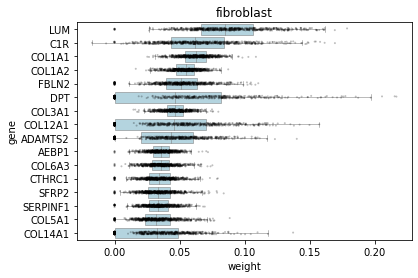

In [139]:
ucd.pl.explain(expl_brca, 'fibroblast', subset = res_subset_fibroblast)

## Plot Figures

### Reload Required Data

In [4]:
# Read in anndata
adata = sc.read_h5ad("data/human_breast_dcis/adata_brca_pp_preds_expl.h5ad")

In [5]:
# Collect deconvolution results
res_primary = ucd.utils.get_deconv_as_df(adata, 'ucdeconvolve_results', 'primary')
res_cancer = ucd.utils.get_deconv_as_df(adata, 'ucdeconvolve_results', 'cancer')

# Collect explanations
expl_brca = ucd.tl.read_explanations_from_anndata(adata)

### Panel A

(5, 5)


/home/jupyter/github_repos/ucdeconvolve_old/ucdeconvolve/_plotting.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


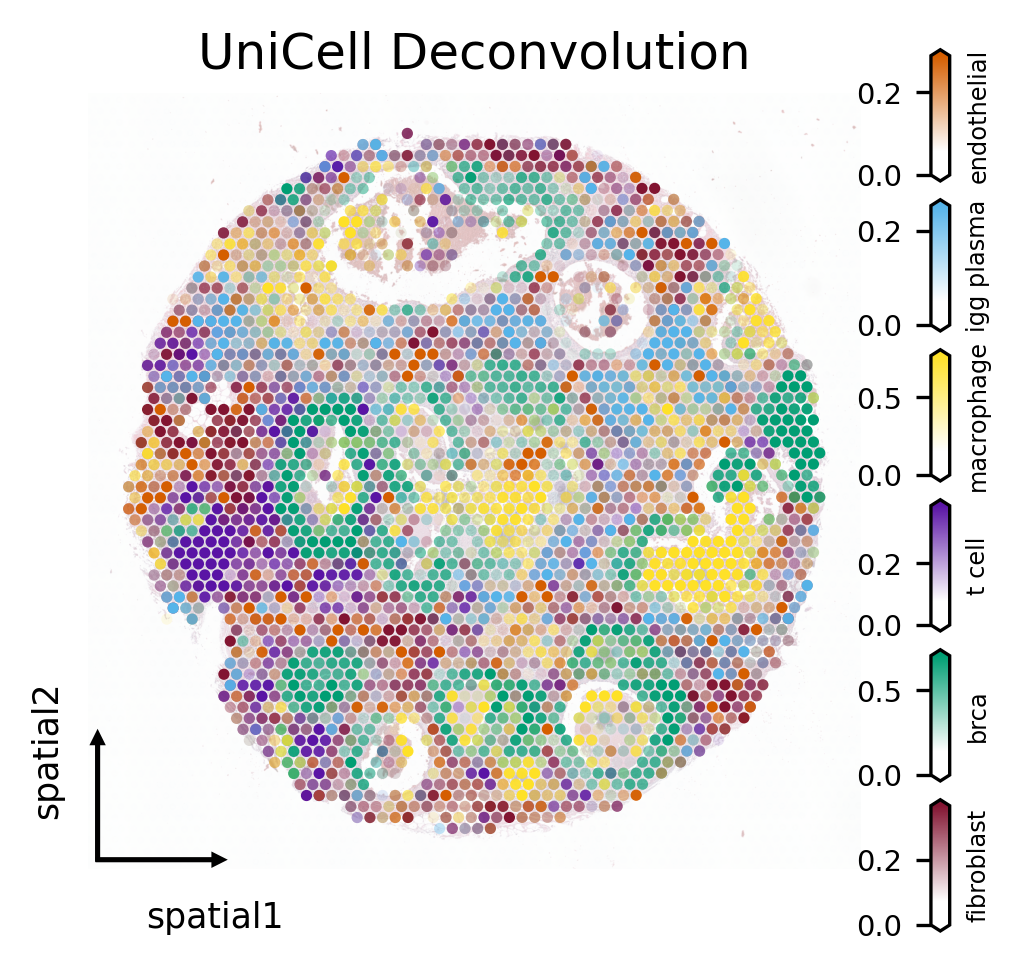

In [7]:
from ucdeconvolve_old.ucdeconvolve.pubscripts.fig3 import append_custom_cbar

with ucd.pl.FigContext(figsize = (5,5), simple_axes = True, 
            simple_axes_padding=(6 * 0.0125), dpi = 300) as ax:
    # Get figure object
    fig = ax.get_figure()
    
    # Define Plot parameters
    cmaps = [ucd.pl.CM.Red, ucd.pl.CM.Green,  ucd.pl.CM.Purple, ucd.pl.CM.Yellow2, ucd.pl.CM.Blue, ucd.pl.CM.Orange]
    celltypes = [('fibroblast', 'primary'), ('brca', 'cancer'), ('t cell', 'primary'), ('macrophage', 'primary'),
                 ('igg plasma cell', 'primary'),('endothelial cell','primary')]
    simple_names = ['Fibroblast', 'BRCA', 'T Cell', 'Macrophage', 'IgG Plasma','Endothelial']
    title = 'UniCell Deconvolution'

    # Plot spatial organization
    for i, ((celltype, category), cmap) in enumerate(zip(celltypes, cmaps)):
        ucd.pl.deconvolution(adata, celltype, ax = ax, show = False, category = category,
                             spot_size = 256, cmap = cmap.value, vmax = "p98", vmin = 0.0,
                            alpha_img = 0.33 if i == 0 else 0.0, frameon = False)
        
    ax.set_title(title)
    #ax.invert_yaxis()

    # Define colorbar padding parameters
    startx, starty, height, pad = 0.625, 0.2, 0.0875, 0.0125

    # Append custom colorbar objects
    for collection, cmap, name in zip(ax.collections, cmaps, simple_names):
        collection.colorbar.ax.set_visible(False)
        
        ax_cbar = append_custom_cbar(fig, collection.colorbar, [startx,starty,pad,height], cmap.value, label = name.lower()) 

        ax_cbar.yaxis.set_ticks_position('left')
        ax_cbar.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax_cbar.yaxis.set_tick_params(which='both', labelsize='x-small')
        ax_cbar.set_ylabel(ax_cbar.get_ylabel(), fontsize = 'xx-small')
        starty += height + pad
    
    # Save figure
    fig.savefig("results/figure4_A.png", dpi = 300)

### Panel B

In [8]:
quantile = 0.98
res_subset_fibroblast = res_primary['fibroblast'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_tcells = res_primary['t cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_brca = res_cancer['brca'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_macrophage = res_primary['macrophage'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_plasma = res_primary['igg plasma cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_endothelial = res_primary['endothelial cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)

(9, 6)


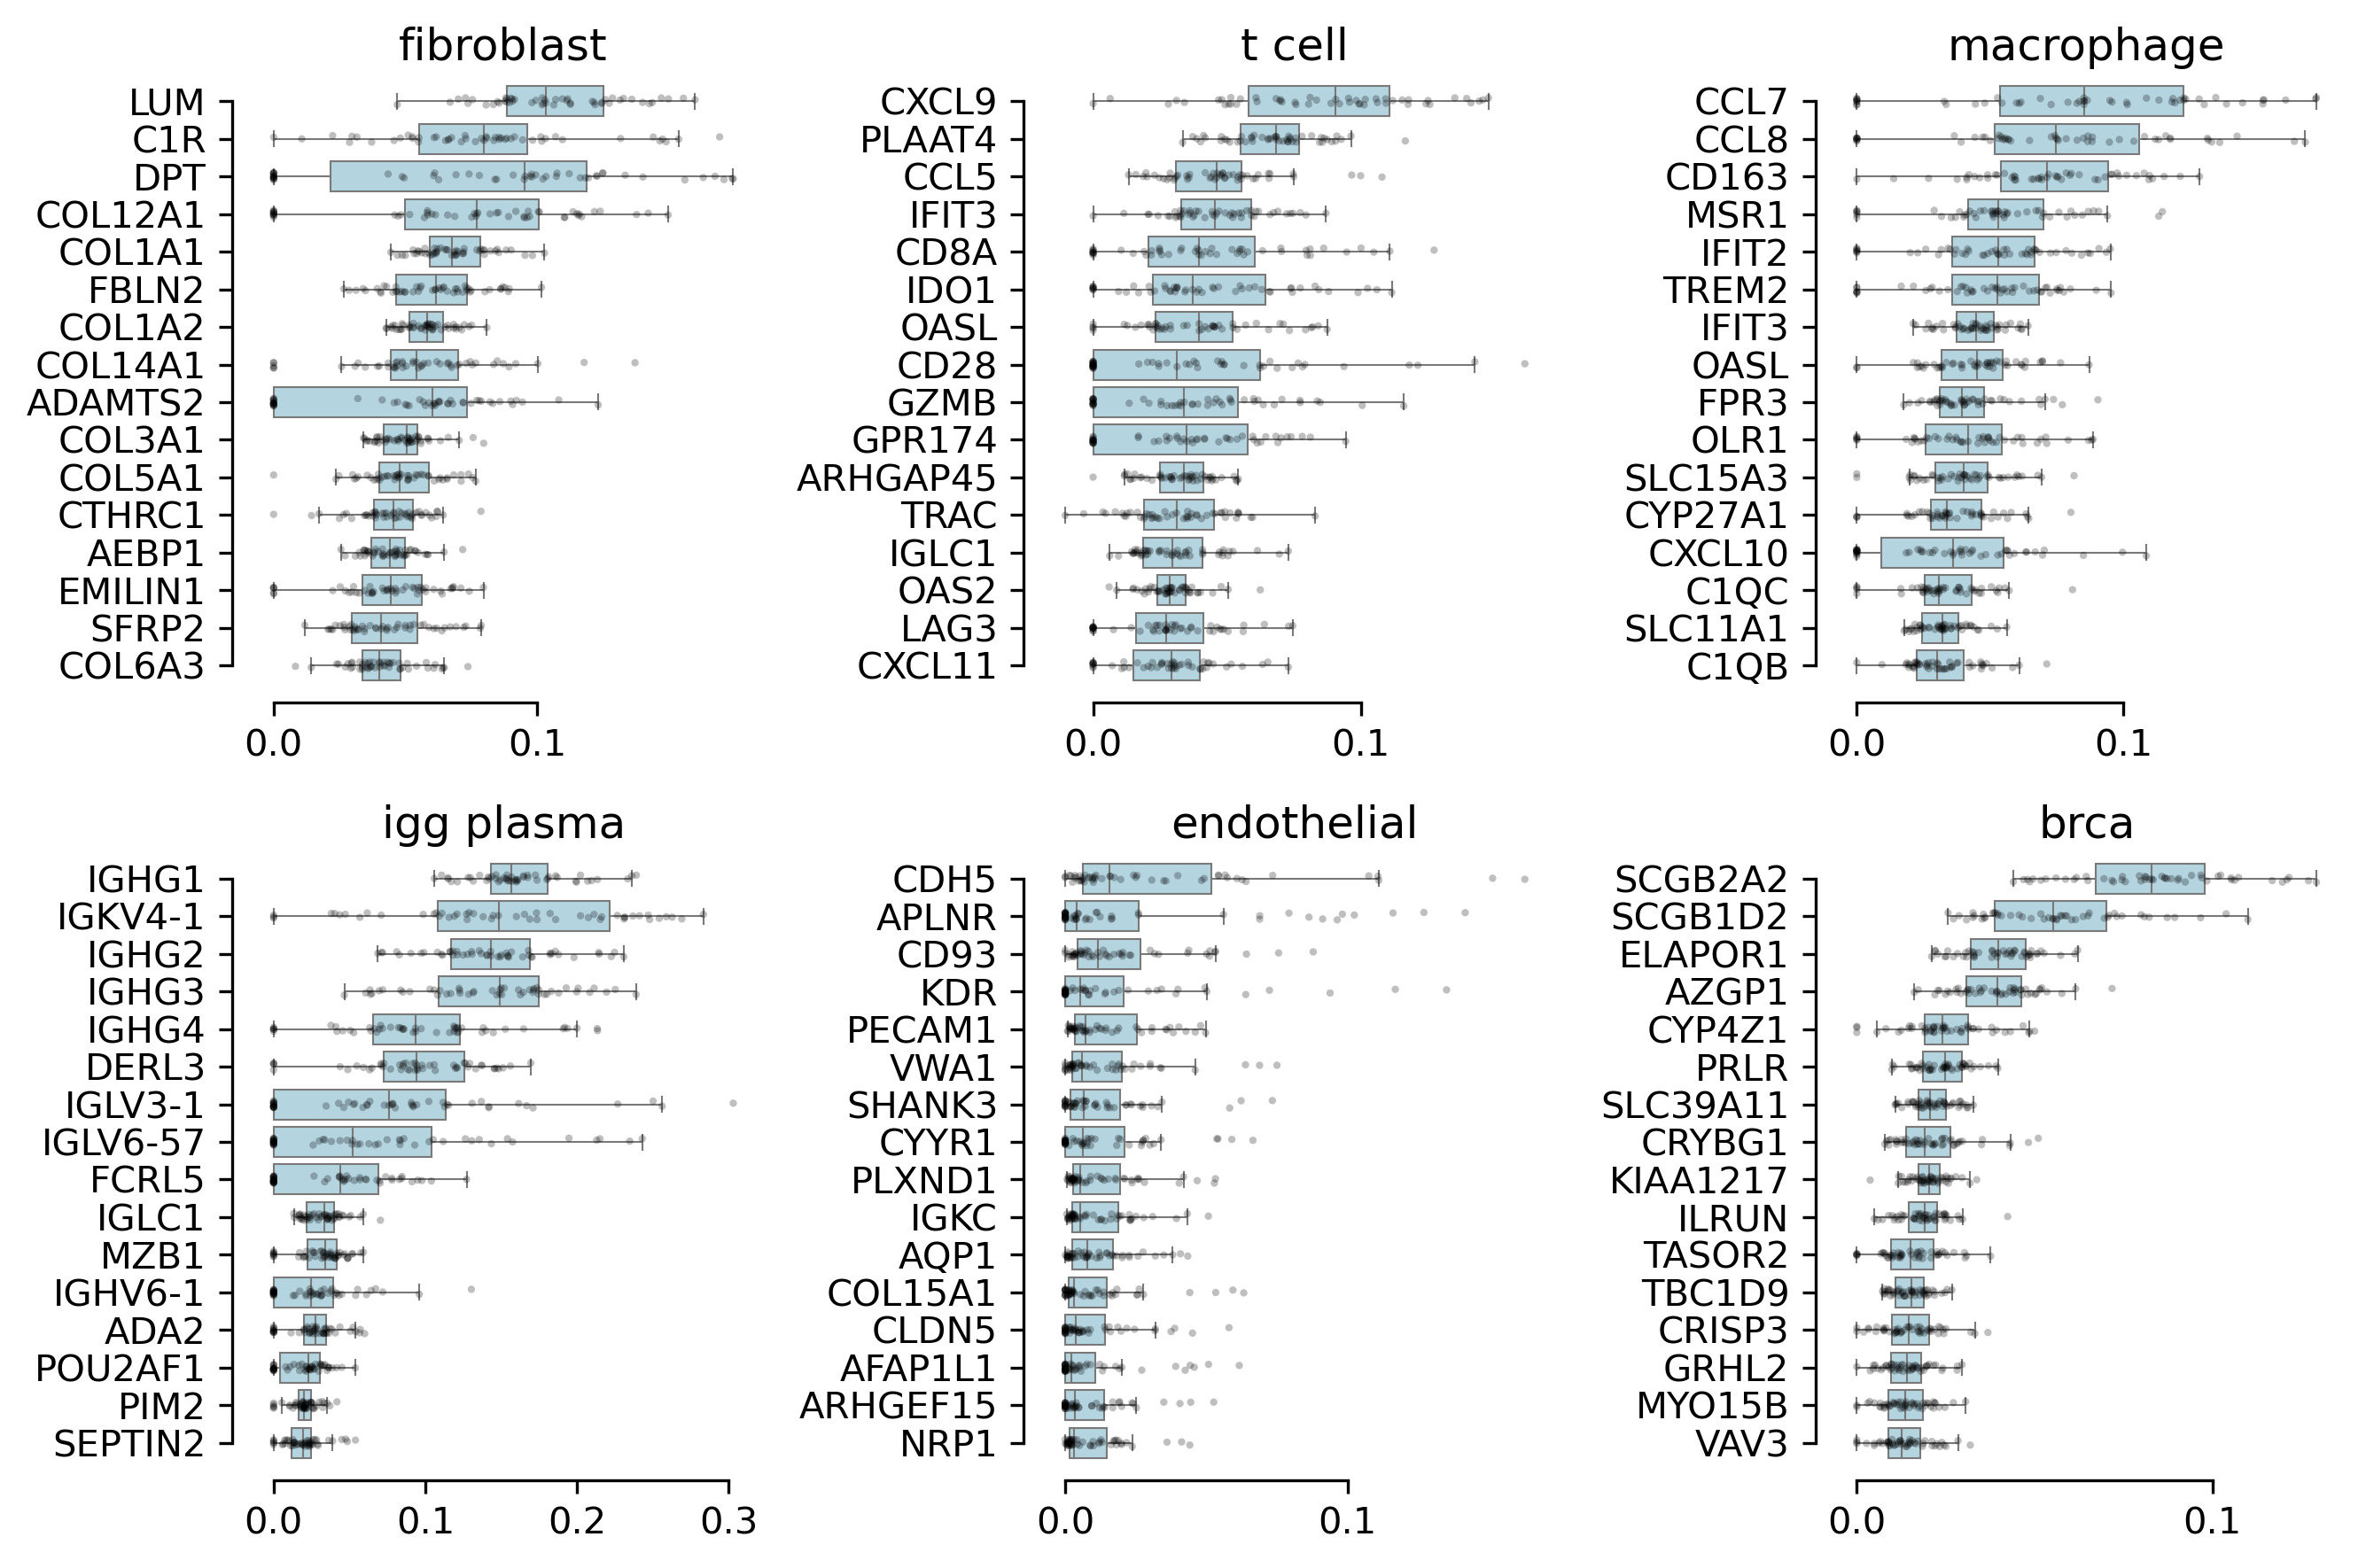

In [10]:
with ucd.pl.FigContext(rows = 2, columns = 3, figsize = (3,3), 
                       dpi = 300, despine=True) as axes:
    
    simple_names = ['fibroblast', 't cell', 'macrophage', 'igg plasma','endothelial', 'brca']
    
    ucd.pl.explain(expl_brca, 'fibroblast', subset = res_subset_fibroblast, ax = axes[0], point_size = 2)
    ucd.pl.explain(expl_brca, 't cell', subset = res_subset_tcells, ax = axes[1], point_size = 2)
    ucd.pl.explain(expl_brca, 'macrophage', subset = res_subset_macrophage, ax = axes[2], point_size = 2)
    ucd.pl.explain(expl_brca, 'igg plasma cell', subset = res_subset_plasma, ax = axes[3], point_size = 2)
    ucd.pl.explain(expl_brca, 'endothelial cell', subset = res_subset_endothelial, ax = axes[4], point_size = 2)
    ucd.pl.explain(expl_brca, 'brca', subset = res_subset_brca, ax = axes[5], point_size = 2)

    for name, ax in zip(simple_names, axes):
        ax.set_title(name)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
        
    # Save figure
    ax.get_figure().savefig("results/figure4_B.png", dpi = 300)

---

# Human Prostate Cancer Adenocarcinoma (PRAD)

---
Origin: https://www.10xgenomics.com/resources/datasets/human-breast-cancer-ductal-carcinoma-in-situ-invasive-carcinoma-ffpe-1-standard-1-3-0

## Download Data, Process, & Predict

In [ ]:
%%bash
cd /home/jupyter/manuscript/figure4/data/human_prostate_adenocarcinoma/

# Download
aria2c https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Cancer/Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5
aria2c https://cf.10xgenomics.com/samples/spatial-exp/1.3.0/Visium_FFPE_Human_Prostate_Cancer/Visium_FFPE_Human_Prostate_Cancer_spatial.tar.gz

#Rename visium data
mv Visium_FFPE_Human_Prostate_Cancer_filtered_feature_bc_matrix.h5 filtered_feature_bc_matrix.h5

# Unpack spatial metadata
tar -xvf Visium_FFPE_Human_Prostate_Cancer_spatial.tar.gz

In [ ]:
# Load data
adata = sc.read_visium("data/human_prostate_adenocarcinoma/")
adata = ucd.tl.quickprocess(adata)

# Perform deconvolution
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

In [190]:
# Assign interesting celltypes to unstructured dictionary
adata.uns['interesting_celltypes'] = [
    ('smooth muscle cell', 'primary'), ('prad', 'cancer'), ('schwann cell', 'primary'), ('myofibroblast', 'primary'),
    ('basal cell', 'primary'),('luminal cell of prostate epithelium','primary')]

# Extract just celltype names
celltype_labels = list(list(zip(*adata.uns['interesting_celltypes']))[0])

# Run explain
expl_prad = ucd.tl.explain(adata, celltype_labels, basemodel, batchsize = 5)

# Save explanations
ucd.tl.write_explanations_to_anndata(adata, expl_prad, key = 'ucd_explanations')

# Save anndata
adata.write_h5ad("data/human_prostate_adenocarcinoma/adata_prad_pp_preds_expl.h5ad")

Explaining Batches | 100% (874 of 874) |#| Elapsed Time: 0:09:12 Time:  0:09:12
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


## Plot Figures

### Reload Required Data

In [24]:
# Read in anndata
adata = sc.read_h5ad("data/human_prostate_adenocarcinoma/adata_prad_pp_preds_expl.h5ad")

In [25]:
# Collect deconvolution results
res_primary = ucd.utils.get_deconv_as_df(adata, 'ucdeconvolve_results', 'primary')
res_cancer = ucd.utils.get_deconv_as_df(adata, 'ucdeconvolve_results', 'cancer')

# Collect explanations
expl_prad = ucd.tl.read_explanations_from_anndata(adata)

### Panel C

(5, 5)


/home/jupyter/github_repos/ucdeconvolve_old/ucdeconvolve/_plotting.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


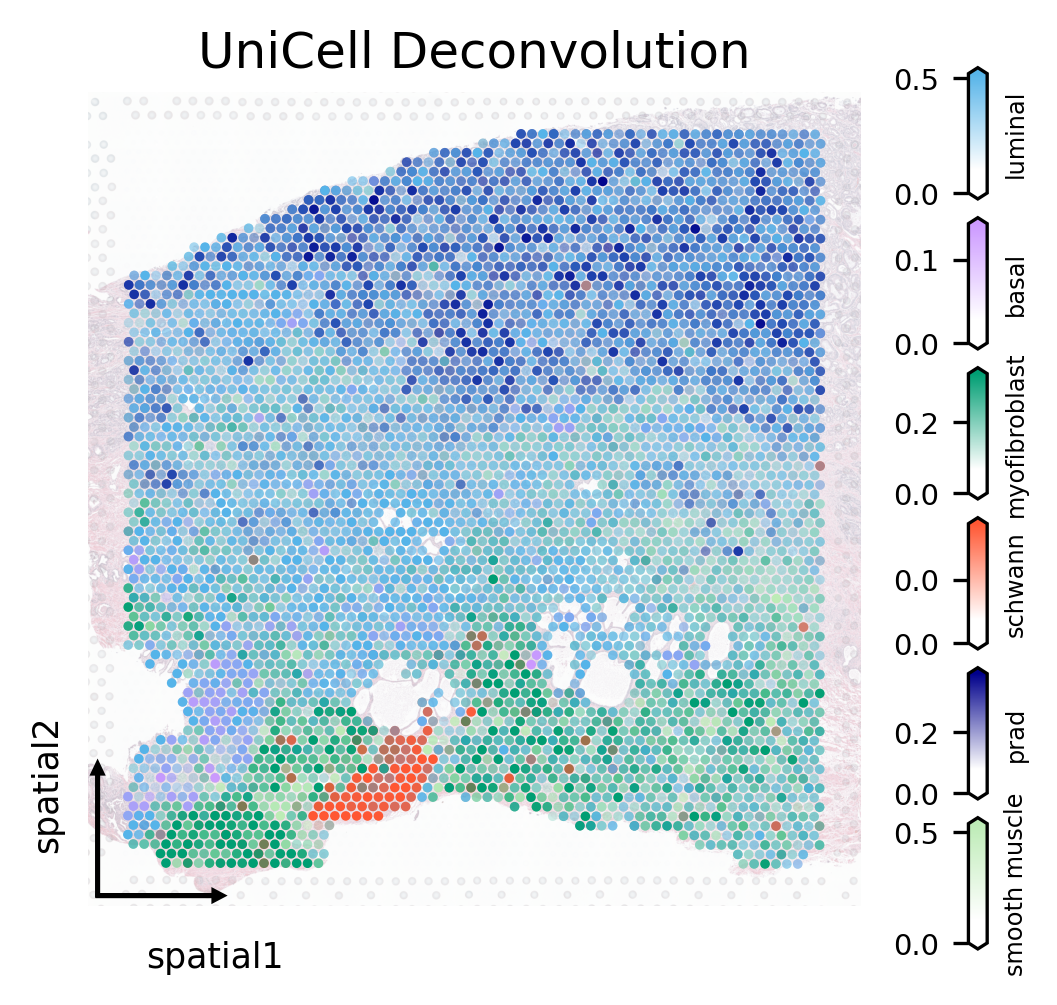

In [26]:
from ucdeconvolve_old.ucdeconvolve.pubscripts.fig3 import append_custom_cbar

with ucd.pl.FigContext(figsize = (5,5), simple_axes = True, 
            simple_axes_padding=(6 * 0.0125), dpi = 300) as ax:
    # Get figure object
    fig = ax.get_figure()
    
    # Define Plot parameters
    cmaps = [ucd.pl.CM.LightGreen, ucd.pl.CM.DarkBlue,  ucd.pl.CM.GreenNeon, ucd.pl.CM.Green, ucd.pl.CM.LightPurple, ucd.pl.CM.Blue]
    celltypes = list(map(tuple, adata.uns['interesting_celltypes']))
    simple_names = ['Smooth Muscle', 'PRAD', 'Schwann', 'Myofibroblast', 'Basal', 'Luminal']
    title = 'UniCell Deconvolution'

    # Plot spatial organization
    for i, ((celltype, category), cmap) in enumerate(zip(celltypes, cmaps)):
        ucd.pl.deconvolution(adata, celltype, ax = ax, show = False, category = category,
                             spot_size = 256, cmap = cmap.value, vmax = "p98", vmin = 0.0,
                            alpha_img = 0.33 if i == 0 else 0.0, frameon = False)
        
    ax.set_title(title)
    ax.invert_yaxis()

    # Define colorbar padding parameters
    startx, starty, height, pad = 0.65, 0.2, 0.0875, 0.0125

    # Append custom colorbar objects
    for collection, cmap, name in zip(ax.collections, cmaps, simple_names):
        collection.colorbar.ax.set_visible(False)
        
        ax_cbar = append_custom_cbar(fig, collection.colorbar, [startx,starty,pad,height], cmap.value, label = name.lower()) 

        ax_cbar.yaxis.set_ticks_position('left')
        ax_cbar.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax_cbar.yaxis.set_tick_params(which='both', labelsize='x-small')
        ax_cbar.set_ylabel(ax_cbar.get_ylabel(), fontsize = 'xx-small')
        starty += height + pad
    
    # Save figure
    fig.savefig("results/figure4_C.png", dpi = 300)

### Panel D

In [15]:
# Only take the top 2% of prediction spots by celltype to look at gene attribution weights
quantile = 0.98

# Get quantiles for each celltype we are intersted in
res_subset_smc = res_primary['smooth muscle cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_prad = res_cancer['prad'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_schwann = res_primary['schwann cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_myofibroblast = res_primary['myofibroblast'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_basal = res_primary['basal cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_luminal = res_primary['luminal cell of prostate epithelium'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)

(9, 6)


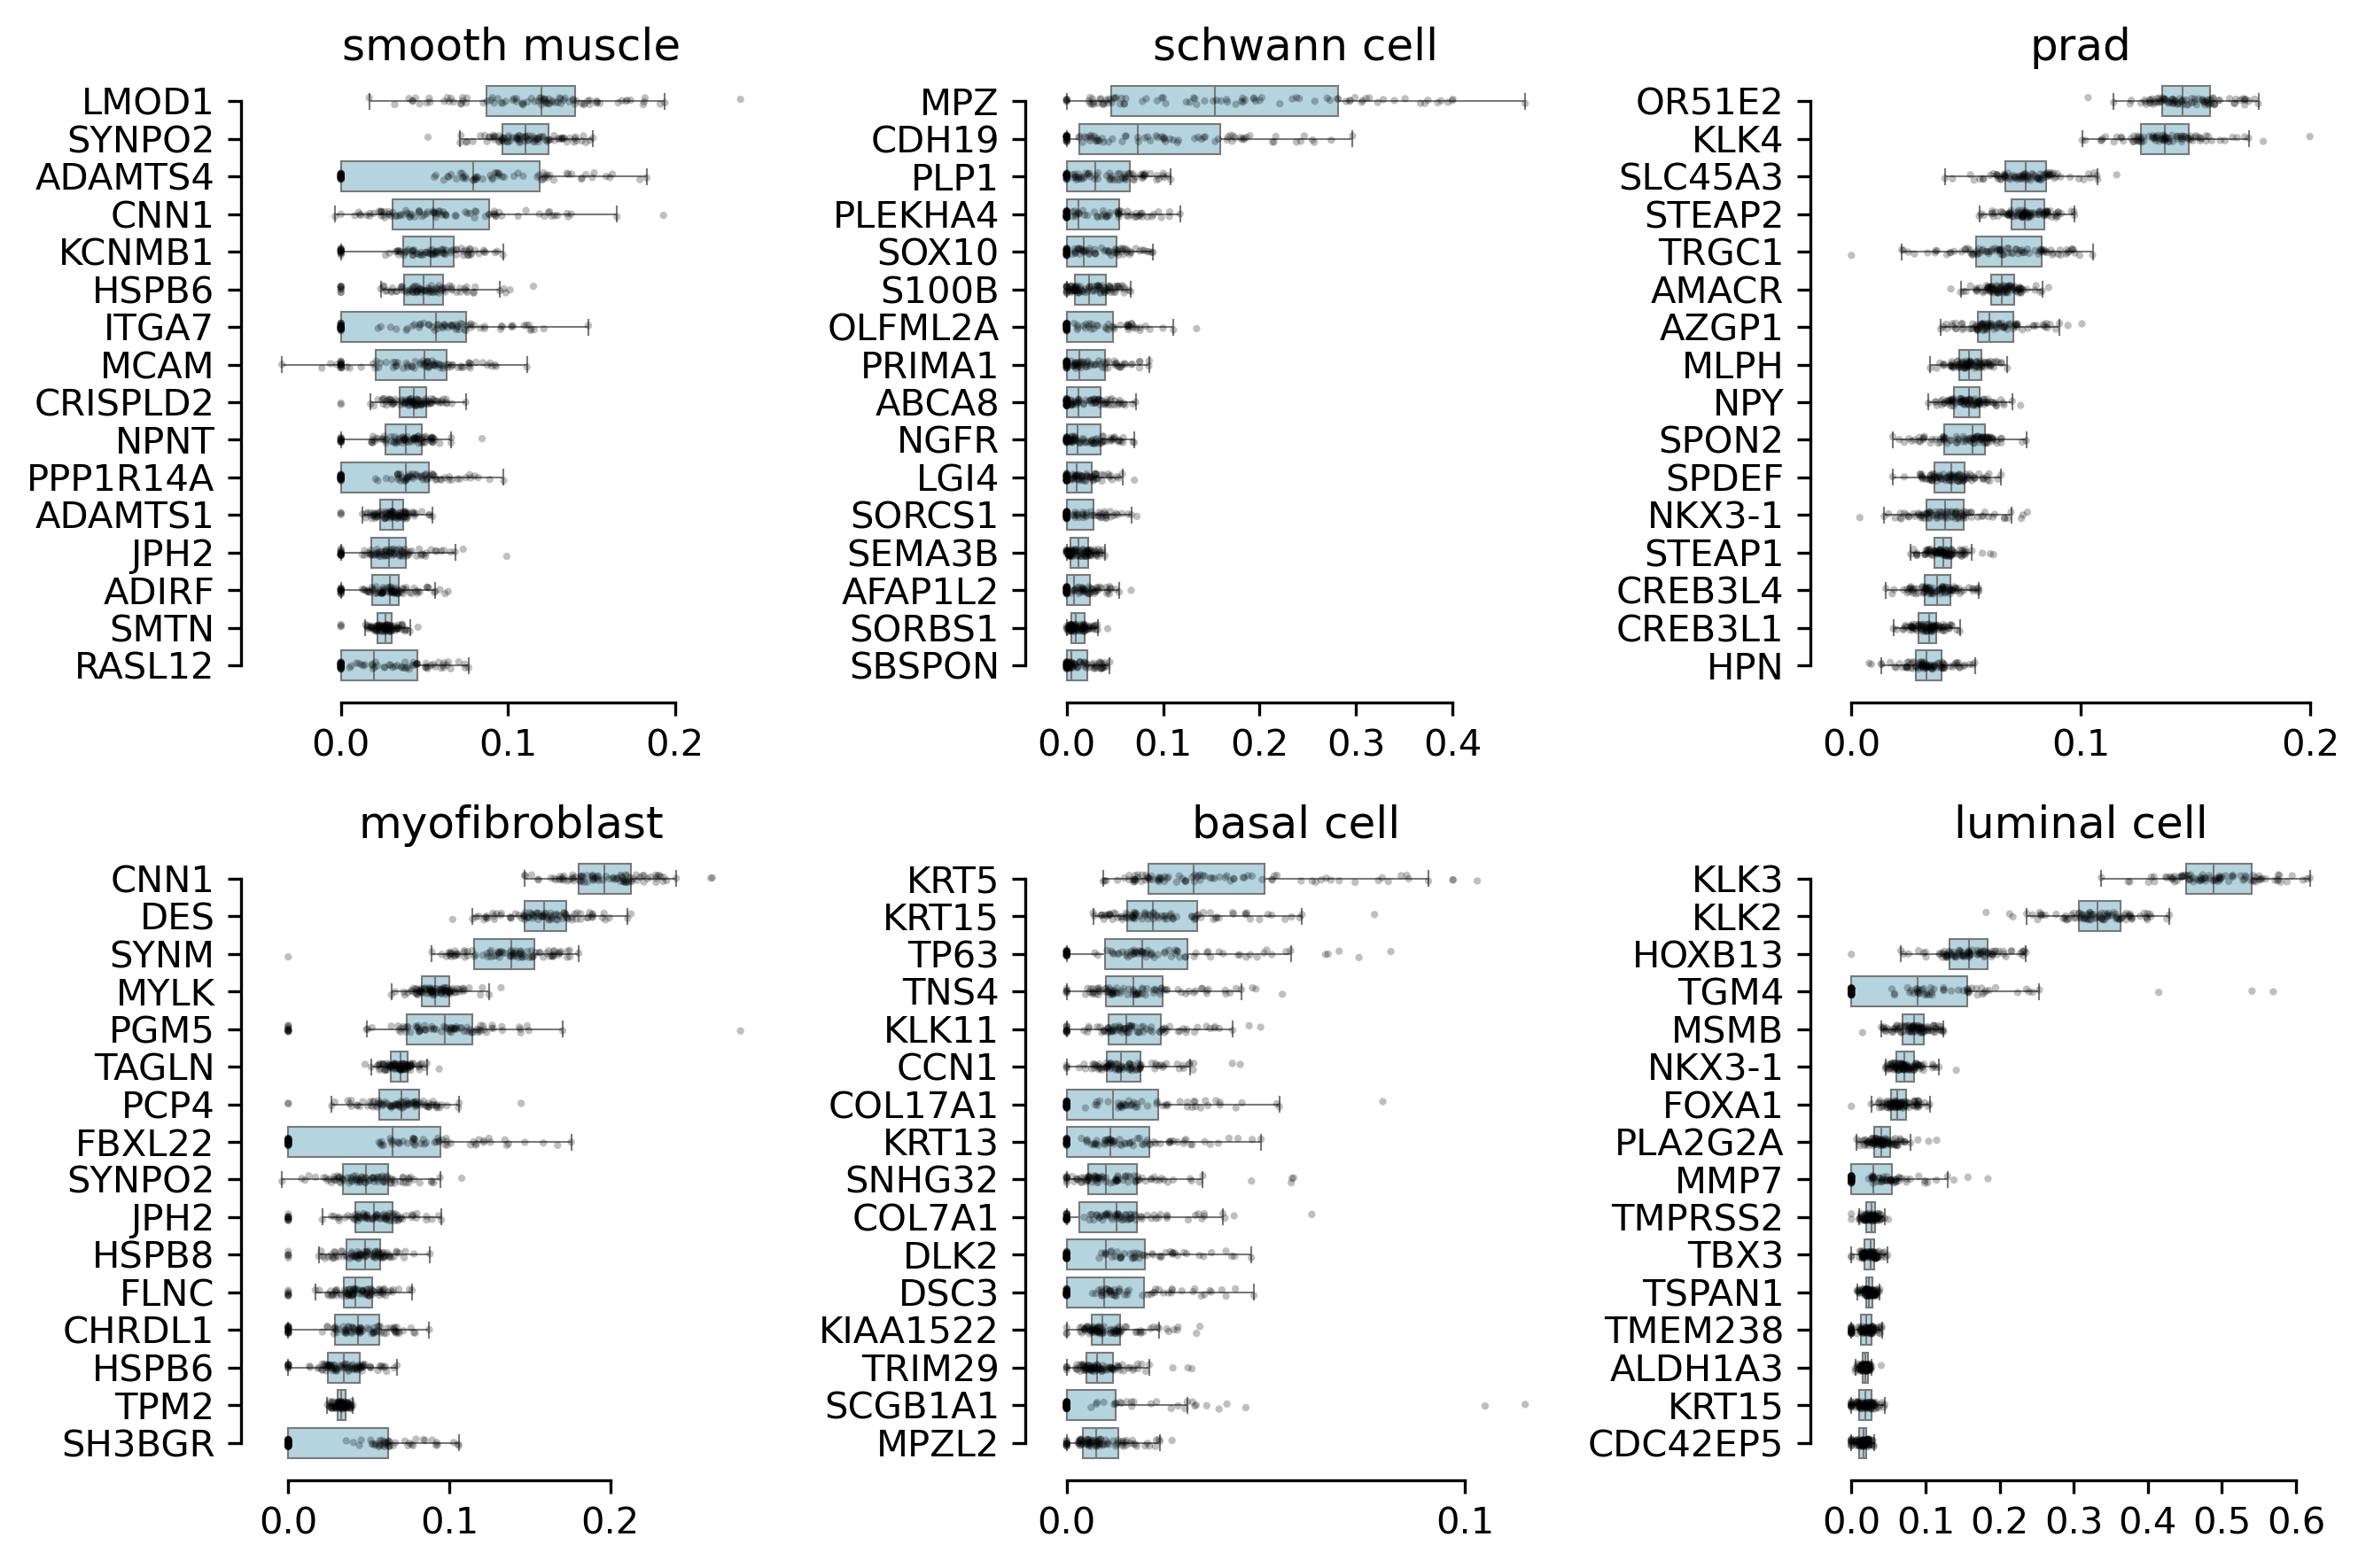

In [16]:
with ucd.pl.FigContext(rows = 2, columns = 3, figsize = (3,3), 
                       dpi = 300, despine=True) as axes:
    
    simple_names = ['smooth muscle', 'schwann cell', 'prad', 'myofibroblast','basal cell', 'luminal cell']
    
    ucd.pl.explain(expl_prad, 'smooth muscle cell', subset = res_subset_smc, ax = axes[0], point_size = 2)
    ucd.pl.explain(expl_prad, 'schwann cell', subset = res_subset_schwann, ax = axes[1], point_size = 2)
    ucd.pl.explain(expl_prad, 'prad', subset = res_subset_prad, ax = axes[2], point_size = 2)
    ucd.pl.explain(expl_prad, 'myofibroblast', subset = res_subset_myofibroblast, ax = axes[3], point_size = 2)
    ucd.pl.explain(expl_prad, 'basal cell', subset = res_subset_basal, ax = axes[4], point_size = 2)
    ucd.pl.explain(expl_prad, 'luminal cell of prostate epithelium', subset = res_subset_luminal, ax = axes[5], point_size = 2)

    for name, ax in zip(simple_names, axes):
        ax.set_title(name)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
        
    # Save figure
    ax.get_figure().savefig("results/figure4_D.png", dpi = 300)

---

# Colorectal Adenocarcinoma (COAD)

---
Origin: "Parent_Visium_Human_ColorectalCancer"

## Download Data, Process, & Predict

In [ ]:
# Load data
adata = sc.datasets.visium_sge("Parent_Visium_Human_ColorectalCancer")
adata = ucd.tl.quickprocess(adata)

# Perform deconvolution
ucd.tl.deconvolve(adata, basemodel, split = True, propagate = True, return_results=False)

In [15]:
# Assign interesting celltypes to unstructured dictionary
adata.uns['interesting_celltypes'] = [
    ('coad', 'cancer'), ('t cell', 'primary'), ('macrophage', 'primary'), 
    ('fibroblast', 'primary'), ('plasmablast', 'primary')]

# Extract just celltype names
celltype_labels = list(list(zip(*adata.uns['interesting_celltypes']))[0])

# Run explain
expl_brca = ucd.tl.explain(adata, celltype_labels, basemodel, batchsize = 5)

# Save explanations
ucd.tl.write_explanations_to_anndata(adata, expl_brca, key = 'ucd_explanations')

# Save anndata
adata.write_h5ad("data/Parent_Visium_Human_ColorectalCancer/adata_coad_pp_preds_expl.h5ad")

Explaining Batches |   0% (0 of 627) |   | Elapsed Time: 0:00:00 ETA:  --:--:--2022-03-23 13:39:35.738304: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x560303874950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-03-23 13:39:35.738348: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2022-03-23 13:39:35.806282: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:133] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.
2022-03-23 13:39:35.852150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-03-23 13:39:40.102618: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Explaining Batches | 100% (627 of 627) |#| Elapsed Time: 0:

## Plot Figures

### Reload Required Data

In [17]:
# Read in anndata
adata = sc.read_h5ad("data/Parent_Visium_Human_ColorectalCancer/adata_coad_pp_preds_expl.h5ad")

In [18]:
# Collect deconvolution results
res_primary = ucd.utils.get_deconv_as_df(adata, 'ucdeconvolve_results', 'primary')
res_cancer = ucd.utils.get_deconv_as_df(adata, 'ucdeconvolve_results', 'cancer')

# Collect explanations
expl_coad = ucd.tl.read_explanations_from_anndata(adata)

### Panel E

(5, 5)


/home/jupyter/github_repos/ucdeconvolve_old/ucdeconvolve/_plotting.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


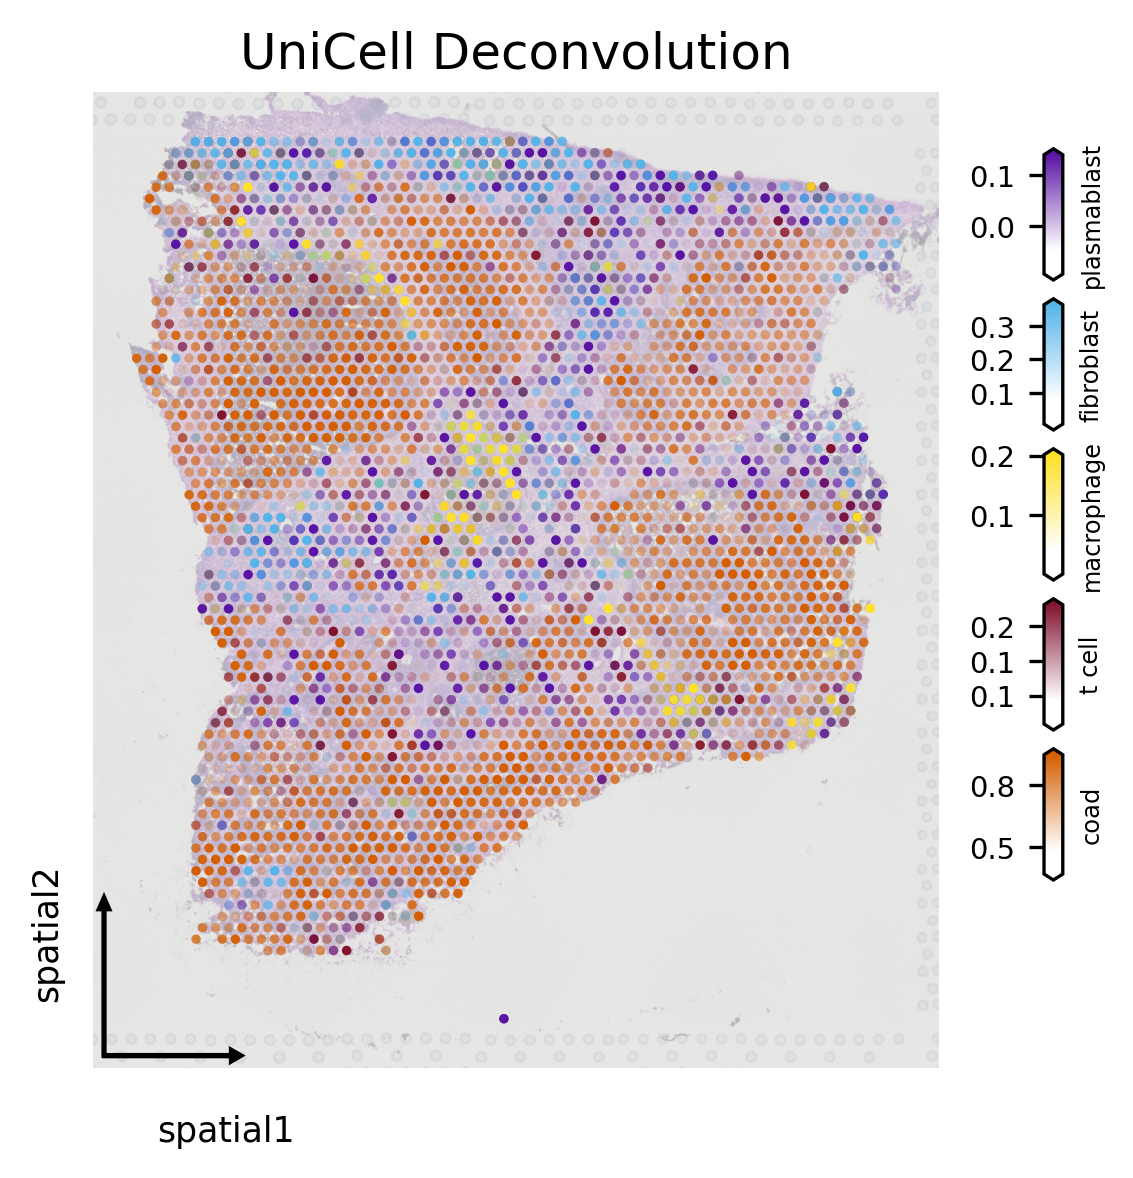

In [19]:
from ucdeconvolve_old.ucdeconvolve.pubscripts.fig3 import append_custom_cbar

with ucd.pl.FigContext(figsize = (5,5), simple_axes = True, 
            simple_axes_padding=(6 * 0.0125), dpi = 300) as ax:
    # Get figure object
    fig = ax.get_figure()
    
    # Define Plot parameters
    cmaps = [ucd.pl.CM.Orange, ucd.pl.CM.Red,  ucd.pl.CM.Yellow2, ucd.pl.CM.Blue, ucd.pl.CM.Purple]
    celltypes = list(map(tuple, adata.uns['interesting_celltypes']))
    simple_names = ['COAD', 'T Cell', 'Macrophage', 'Fibroblast', 'Plasmablast']
    title = 'UniCell Deconvolution'

    # Plot spatial organization
    for i, ((celltype, category), cmap) in enumerate(zip(celltypes, cmaps)):
        ucd.pl.deconvolution(adata, celltype, ax = ax, show = False, category = category,
                             spot_size = 100, cmap = cmap.value, vmax = "p98", vmin = "p20",
                            alpha_img = 0.33 if i == 0 else 0.0, frameon = False)
        
    ax.set_title(title)
    #ax.invert_yaxis()

    # Define colorbar padding parameters
    startx, starty, height, pad = 0.7, 0.3, 0.0875, 0.0125

    # Append custom colorbar objects
    for collection, cmap, name in zip(ax.collections, cmaps, simple_names):
        collection.colorbar.ax.set_visible(False)
        
        ax_cbar = append_custom_cbar(fig, collection.colorbar, [startx,starty,pad,height], cmap.value, label = name.lower()) 

        ax_cbar.yaxis.set_ticks_position('left')
        ax_cbar.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax_cbar.yaxis.set_tick_params(which='both', labelsize='x-small')
        ax_cbar.set_ylabel(ax_cbar.get_ylabel(), fontsize = 'xx-small')
        starty += height + pad
    
    # Save figure
    fig.savefig("results/figure4_E.png", dpi = 300)

### Panel F

In [21]:
# Only take the top 2% of prediction spots by celltype to look at gene attribution weights
quantile = 0.98

# Get quantiles for each celltype we are intersted in
res_subset_tcell = res_primary['t cell'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_coad = res_cancer['coad'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_macrophage = res_primary['macrophage'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_fibroblast = res_primary['fibroblast'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)
res_subset_plasmablast = res_primary['plasmablast'].pipe(lambda x : x[x.ge(x.quantile(quantile))].index)

(9, 6)


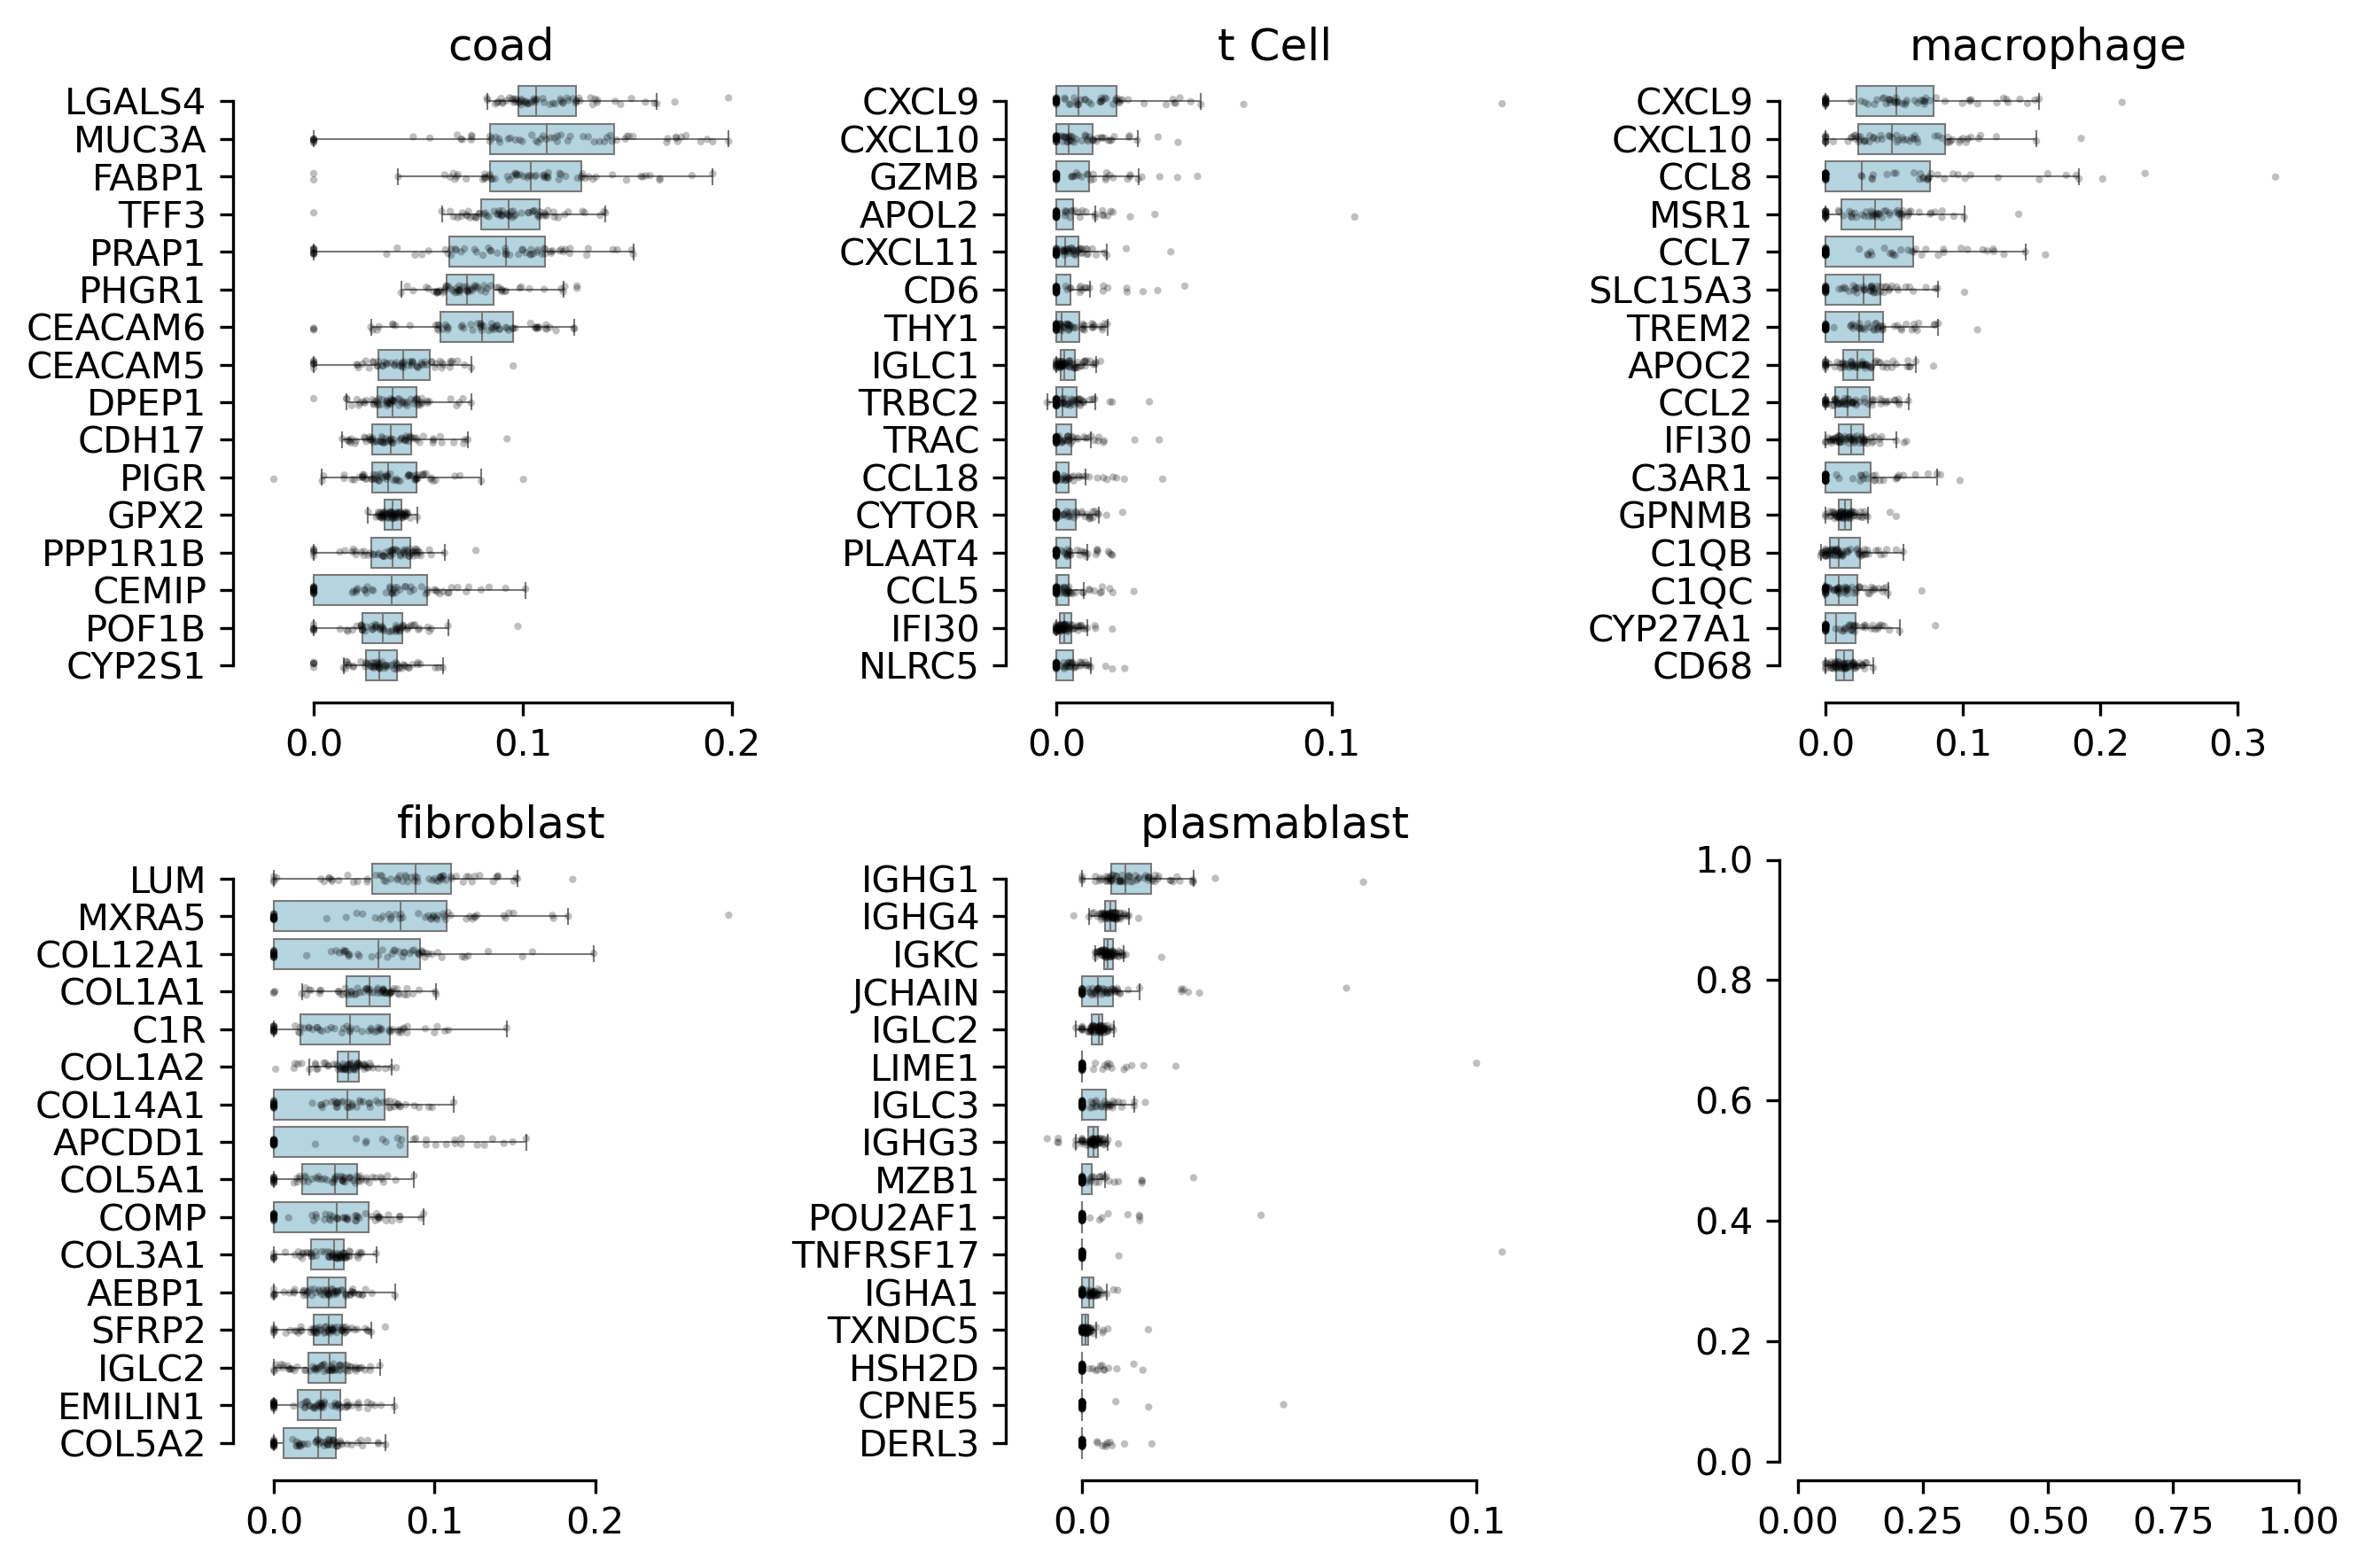

In [22]:
with ucd.pl.FigContext(rows = 2, columns = 3, figsize = (3,3), 
                       dpi = 300, despine=True) as axes:
    
    simple_names = ['coad', 't Cell', 'macrophage','fibroblast', 'plasmablast']
    
    ucd.pl.explain(expl_coad, 'coad', subset = res_subset_coad, ax = axes[0], point_size = 2)
    ucd.pl.explain(expl_coad, 't cell', subset = res_subset_tcell, ax = axes[1], point_size = 2)
    ucd.pl.explain(expl_coad, 'macrophage', subset = res_subset_macrophage, ax = axes[2], point_size = 2)
    ucd.pl.explain(expl_coad, 'fibroblast', subset = res_subset_fibroblast, ax = axes[3], point_size = 2)
    ucd.pl.explain(expl_coad, 'plasmablast', subset = res_subset_plasmablast, ax = axes[4], point_size = 2)

    for name, ax in zip(simple_names, axes):
        ax.set_title(name)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
        
    # Save figure
    ax.get_figure().savefig("results/figure4_F.png", dpi = 300)